In [1]:
# Import libraries
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('rfsoc_lib')
from rfsoc_calibration import RfsocCalibration
from rfsoc_pulses import RfsocPulses
from rfsoc_arb_pulses import RfsocArbPulses

import pickle
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [3]:
# Board libraries
from qick import *
import Pyro4

# Pyro communicates with board
Pyro4.config.SERIALIZER = "pickle"
Pyro4.config.PICKLE_PROTOCOL_VERSION=4

# Static IP proxy
ns_host = "192.168.2.99" # <-- SET IP ADDRESS
ns_port = 8888
proxy_name = "myqick"

# QICK object
ns = Pyro4.locateNS(host=ns_host, port=ns_port)
soc = Pyro4.Proxy(ns.lookup(proxy_name))
soccfg = QickConfig(soc.get_cfg())
print(soccfg)


QICK configuration:

	Board: RFSoC4x2

	Software version: 0.2.267
	Firmware timestamp: Thu Sep 28 15:12:10 2023

	Global clocks (MHz): tProcessor 307.200, RF reference 409.600

	2 signal generator channels:
	0:	axis_signal_gen_v6 - envelope memory 65536 samples (13.333 us)
		fs=4915.200 MHz, fabric=307.200 MHz, 32-bit DDS, range=4915.200 MHz
		DAC tile 0, blk 0 is DAC_B
	1:	axis_signal_gen_v6 - envelope memory 65536 samples (13.333 us)
		fs=4915.200 MHz, fabric=307.200 MHz, 32-bit DDS, range=4915.200 MHz
		DAC tile 2, blk 0 is DAC_A

	2 readout channels:
	0:	axis_readout_v2 - configured by PYNQ
		fs=2457.600 MHz, decimated=307.200 MHz, 32-bit DDS, range=2457.600 MHz
		maxlen 16384 accumulated, 1024 decimated (3.333 us)
		triggered by output 7, pin 14, feedback to tProc input 0
		ADC tile 0, blk 0 is ADC_D
	1:	axis_readout_v2 - configured by PYNQ
		fs=2457.600 MHz, decimated=307.200 MHz, 32-bit DDS, range=2457.600 MHz
		maxlen 16384 accumulated, 1024 decimated (3.333 us)
		triggered by

In [122]:
# Import DAC and ssb calibrations
with open('pickles/calibrate_phase.pickle', 'rb') as handle:
    dac_phis = pickle.load(handle)

with open('pickles/ssb_params_30000.pickle', 'rb') as handle:
    ssb_params = pickle.load(handle)

with open('pickles/const_power.pickle', 'rb') as handle:
    const_power = pickle.load(handle)

for key, value in const_power.items():
    const_power[key] = value/2

calibration = RfsocCalibration(dac_phis,
                            #    ssb_params = ssb_params,
                            #    const_power = const_power,
                            #    gain_factor = 0.5,
                               )

In [23]:
# ------ SEQUENCE PRODUCT ------
# Frequency: FIXED
# Phase: Var
# Amplitude: Var
# product_seq = ([20, 1.0, 0.1, 0], [20, 1.0, 0.1, 180], [10,0], [50, 1.0, 0.1, 0])
product_seq_a = ([10, 0], [0.8, 0], [20, 1.0, 0.2, 0], [10, 0], [20, 1.0, 0.2, 0])
product_seq_b = ([10, 0], [20, 1.0, 0.2, 0], [10, 0], [20, 1.0, 0.2, 0])
product_obj_a = RfsocArbPulses(soccfg,
                            #    calibration=calibration,
                               sequence=product_seq_a, outsel='product', ch_index=1)
product_obj_b = RfsocArbPulses(soccfg,
                            #    calibration=calibration,
                               sequence=product_seq_b, outsel='product', ch_index=0)

# ------ SEQUENCE INPUT -------
# Frequency: Var
# Phase: Var
# Amplitude: Var
# input_seq = ([10, 0.8, 0.1, 90], [10, 0], [50, 1.0, 0.1, 0])
input_seq_a = [(0.8, 0), (20, 1.0, 0.2, 0), (10, 0), (20, 1.0, 0.1, 0)]
input_seq_b = [(20, 1.0, 0.2, 0), (10, 0), (20, 1.0, 0.1, 0)]
input_obj_a = RfsocArbPulses(soccfg,
                            #  calibration=calibration,
                             sequence=input_seq_a, outsel='input', ch_index=1)
input_obj_b = RfsocArbPulses(soccfg,
                            #  calibration=calibration,
                             sequence=input_seq_b, outsel='input', ch_index=0)

# samples = [[], []]
# for i in range(196):
#     samples[0].append(-32566)
#     samples[1].append(0)
# # for i in range(100):
# #     samples[0].append(0)
# #     samples[1].append(32566)

# # ------ SAMPLES PRODUCT ------
# samples_product_obj = RfsocArbPulses(soccfg,
#                                     #  calibration=calibration,
#                                      samples=samples, outsel='product', ch_index=1, freq=0.2)

# # ------ SAMPLES INPUT -----
# samples_input_obj = RfsocArbPulses(soccfg,
#                                 #    calibration=calibration,
#                                    samples=samples, outsel='input', ch_index=1)

# dac_seq = [input_obj, (10, 0), (20, 1.0, 0.1, 0), (10, 0), product_obj, (10, 0), samples_product_obj, (10, 0), (20, 1.0, 0.1, 0), (10, 0), samples_input_obj]
# dac_seq_a = [input_obj_a, (10, 0), (20, 1.0, 0.2, 0), product_obj_a]
# dac_seq_b = [input_obj_b, (10, 0), (20, 1.0, 0.2, 0), product_obj_b]
dac_seq_a = [input_obj_a, (10, 0), (20, 1.0, 0.2, 0), product_obj_a, ]
dac_seq_b = [input_obj_b, (10, 0), (20, 1.0, 0.2, 0), product_obj_b, ]
sequences = {'DAC_A': dac_seq_a, 'DAC_B': dac_seq_b, 'DIG_0': [(10, 1)]}

delays = {"DAC_A": 0, "DAC_B": 0, "DIG_0": 38}
gains = {'DAC_A': 32766/2, 'DAC_B': 32766/2}

pulses = RfsocPulses(sequences,
                    #  calibration,
                     delays=delays,
                     gains=gains,
                     print_params=True
                     )

AttributeError: 'NoneType' object has no attribute 'ssb_params'

In [286]:
input_seq_a = ([0.8, 0], [20, 1.0, 0.1, 0], [10, 0], [20, 1.0, 0.2, 0])
input_seq_b = ([20, 1.0, 0.1, 0], [10, 0], [20, 1.0, 0.2, 0])
input_obj_a = RfsocArbPulses(soccfg,
                               calibration=calibration,
                               sequence=input_seq_a, outsel='input', ch_index=1)
input_obj_b = RfsocArbPulses(soccfg,
                               calibration=calibration,
                               sequence=input_seq_b, outsel='input', ch_index=0)

product_seq_a = ([10.8, 0], [20, 1.0, 0.2, 0])
product_seq_b = ([10, 0], [20, 1.0, 0.2, 0])
product_obj_a = RfsocArbPulses(soccfg,
                               calibration=calibration,
                               sequence=product_seq_a, outsel='product', ch_index=1)
product_obj_b = RfsocArbPulses(soccfg,
                               calibration=calibration,
                               sequence=product_seq_b, outsel='product', ch_index=0)

dac_seq_a = [input_obj_a, product_obj_a, (10, 0), (20, 1.0, 0.2, 0)]
dac_seq_b = [input_obj_b, product_obj_b, (11, 0), (20, 1.0, 0.2, 0)]
sequences = {'DAC_A': dac_seq_a, 'DAC_B': dac_seq_b, 'DIG_0': [(10, 1)]}

delays = {"DAC_A": 0, "DAC_B": 0, "DIG_0": 38}
gains = {'DAC_A': 32566/2, 'DAC_B': 32566/2}

pulses = RfsocPulses(sequences,
                     calibration,
                     delays=delays,
                     gains=gains,
                     print_params=True
                     )


---------- DAC A ----------
CONFIG
	ch_type: DAC
	ch_index: 1
	delay: 0
	gain: 16283.0
	calibrated: True
	abs_gain: False
	num_pulses: 3
	duration: 0.11159999999999999
PULSES
	lengths: [0.0508, 0.0308, 0.02]
	times: [0.0, 0.0508, 0.0916]
	amps: [None, None, 1.0]
	gains: [32566, 32566, 16283]
	freqs: [0.0, 200.0, 200.0]
	phases: [None, None, 0.0]
	styles: ['arb', 'arb', 'const']
	outsels: ['input', 'product', None]
CALIBRATION
	gains: [32566, 32566, 16283]
	phases: [0.0, 0.0, 0.0]

---------- DAC B ----------
CONFIG
	ch_type: DAC
	ch_index: 0
	delay: 0
	gain: 16283.0
	calibrated: True
	abs_gain: False
	num_pulses: 3
	duration: 0.111
PULSES
	lengths: [0.05, 0.03, 0.02]
	times: [0.0, 0.05, 0.091]
	amps: [None, None, 1.0]
	gains: [32566, 32566, 16283]
	freqs: [0.0, 200.0, 200.0]
	phases: [None, None, 0.0]
	styles: ['arb', 'arb', 'const']
	outsels: ['input', 'product', None]
CALIBRATION
	gains: [32566, 32566, 16283]
	phases: [0.0, 0.0, 310.5101]

---------- DIG 0 ----------
CONFIG
	ch_type

In [292]:
prog = QickProgram(soccfg)
pulses.generate_asm(prog, reps=1)
# pulses.generate_asm(prog, reps=1)
pulses.config_internal_start(soc, prog)
soc.tproc.start() # Run program
print(prog)

16282.965941807972
32566.0
16282.965941807972
21154.2744149094

// Program

        synci 200;
        regwi 0, $14, 0;
LOOP_I: regwi 1, $22, 0;                        //freq = 0
        regwi 1, $23, 0;                        //phase = 0
        regwi 1, $25, 32566;                    //gain = 32566
        regwi 1, $24, 0;                        //addr = 0
        regwi 1, $26, 655376;                   //phrst| stdysel | mode | | outsel = 0b01010 | length = 16 
        regwi 1, $27, 0;                        //t = 0
        set 1, 1, $22, $23, $24, $25, $26, $27; //ch = 1, pulse @t = $27
        regwi 1, $22, 174762667;                //freq = 174762667
        regwi 1, $23, 0;                        //phase = 0
        regwi 1, $25, 32566;                    //gain = 32566
        regwi 1, $24, 16;                       //addr = 16
        regwi 1, $26, 524298;                   //phrst| stdysel | mode | | outsel = 0b01000 | length = 10 
        regwi 1, $27, 16;                   

In [157]:
soc.reset_gens()

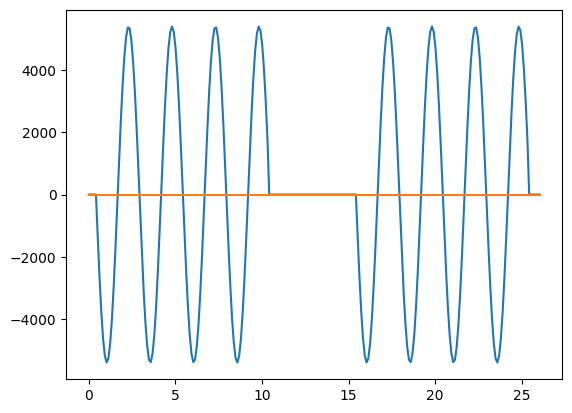

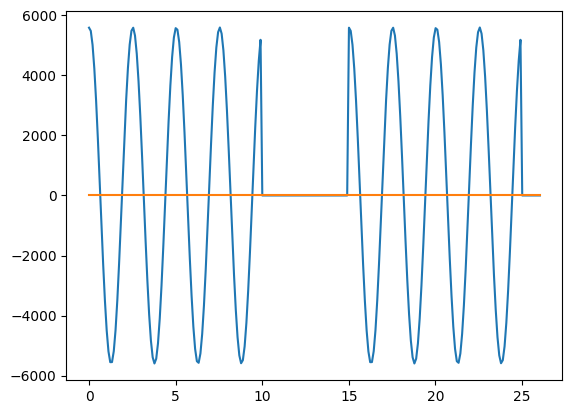

In [11]:
# x = np.arange(0, round(len(input_obj_a.idata) * 1e3 / 9830.4, 2), 1e3 / 9830.4)
# plt.plot(x, -input_obj_a.idata)
# plt.plot(x, input_obj_a.qdata)
# plt.show()

x = np.linspace(0, round(len(product_obj_a.idata) * 1e3 / 9830.4, 2), len(product_obj_a.idata))
plt.plot(x, product_obj_a.idata)
plt.plot(x, product_obj_a.qdata)
plt.show()

x = np.linspace(0, round(len(product_obj_b.idata) * 1e3 / 9830.4, 2), len(product_obj_b.idata))
plt.plot(x, product_obj_b.idata)
plt.plot(x, product_obj_b.qdata)
plt.show()

# x = np.linspace(0, round(len(samples_obj.idata) * 1e3 / 9830.4, 2), len(samples_obj.idata))
# plt.plot(x, -samples_obj.idata)
# plt.plot(x, -samples_obj.qdata)
# plt.show()